# Japan Deflation Analysis

- https://www.boj.or.jp/statistics/money/ms/index.htm/ (Single Data)
- https://www.e-stat.go.jp/statistics-by-theme/ (Multiple Data)
- https://www.boj.or.jp/statistics/index.htm/ (Multiple Data)
- https://data.worldbank.org/indicator (Multiple Data)
- https://stats.oecd.org/# (Multiple Data) Use this 

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# visualization
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

sns.set(color_codes=True)

In [2]:
def transform_dataset(data):
    data = data.set_index('Unnamed: 0')
    data.index.rename('', inplace=True)
    return data

In [3]:
# import relevant dataset
full_data = pd.read_csv('data/full_data.csv')
economic_index = pd.read_csv('data/ei_combined.csv')
cpi_index = pd.read_csv('data/cpi_index.csv')
gdp_production_index = pd.read_csv('data/gdp_production_index.csv')
health_index = pd.read_csv('data/health_index.csv')
population_index = pd.read_csv('data/population_index.csv')
ppp_index = pd.read_csv('data/ppp_index.csv')
productivity_ulc_index = pd.read_csv('data/productivity_ulc_index.csv')

# transform relevant dataset
full_data = transform_dataset(full_data)
economic_index = transform_dataset(economic_index)
cpi_index = transform_dataset(cpi_index)
gdp_production_index = transform_dataset(gdp_production_index)
health_index = transform_dataset(health_index)
population_index = transform_dataset(population_index)
ppp_index = transform_dataset(ppp_index)
productivity_ulc_index = transform_dataset(productivity_ulc_index)

population_index = population_index.drop(columns=['89'])

## Introduction

In [4]:
cpi_history = pd.read_csv('data/cpi.csv')
oecd_cpi = cpi_index['CPI: 01-12 - All items']

In [5]:
cpi_history = cpi_history.loc[cpi_history['Subject'] == 'CPI: 01-12 - All items'][['Country', 'Time', 'Value']]
cpi_japan = cpi_history.loc[cpi_history['Country'] == 'Japan']
cpi_world = cpi_history.loc[cpi_history['Country'] != 'Japan']

In [6]:
time_series = cpi_world['Time'].unique()
avg_cpi = []

for time in time_series:
    avg_cpi.append(cpi_world.loc[cpi_world['Time'] == time]['Value'].mean())

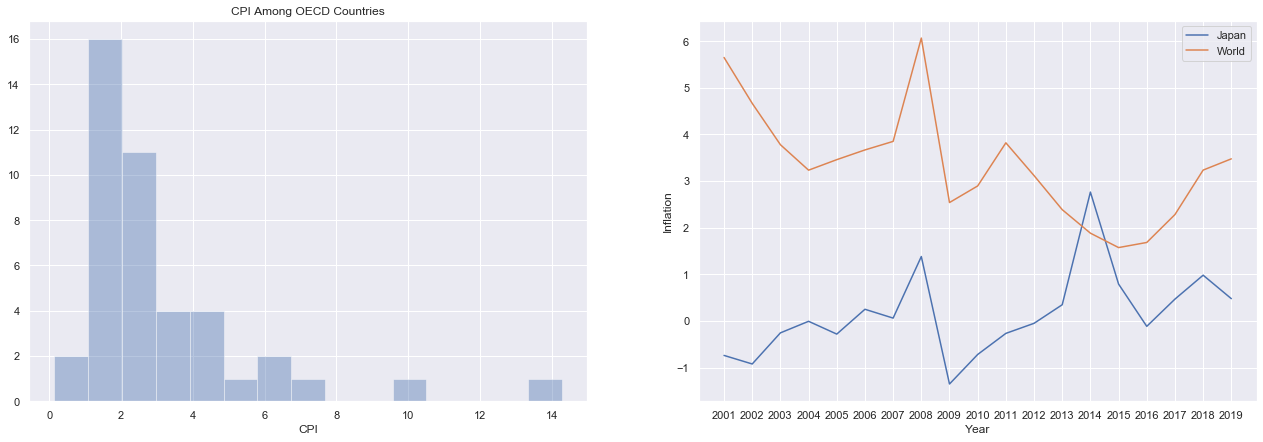

In [7]:
plt.figure(figsize = (22, 7))

plt.subplot(1, 2, 1)
sns.distplot(oecd_cpi.values, kde=False)
plt.xlabel('CPI')
plt.title('CPI Among OECD Countries')

plt.subplot(1, 2, 2)
plt.plot(cpi_japan['Time'], cpi_japan['Value'], label="Japan")
plt.plot(cpi_japan['Time'], avg_cpi, label="World")
plt.xticks(range(2001, 2020, 1))
plt.xlabel('Year')
plt.ylabel('Inflation')
plt.legend()
plt.show()

## Finding similar countries to Japan

In this section we use t-SNE on the dataset to create a scatter plot, and find the countries that are close to Japan in terms of the distance between coordinates on the scatter plot.

### Principal Component Analysis (PCA)

In [8]:
data_reduced = PCA(n_components=2).fit_transform(full_data)

In [9]:
japan = data_reduced[22]
others = np.delete(data_reduced, 22, axis=0)

country_data = [x for x in full_data.index if x != 'Japan']

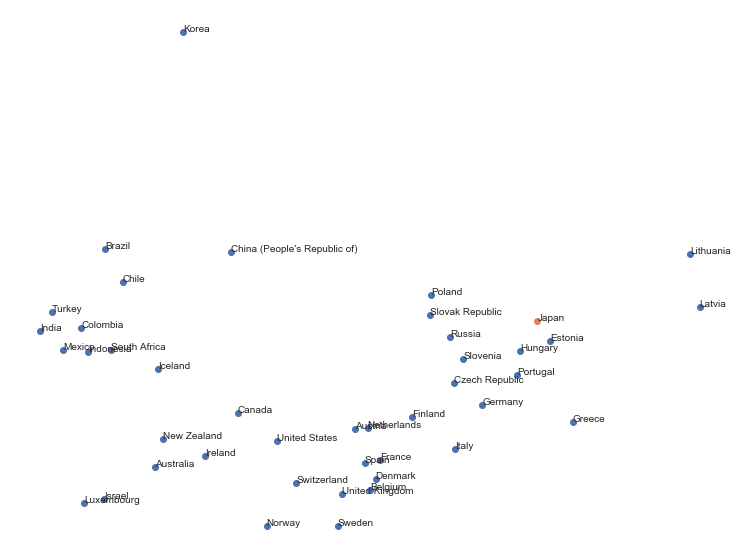

In [10]:
# plot scatter graph
plt.figure(figsize=(13,10))
plt.scatter(others[:, 0], others[:, 1])
plt.scatter(japan[0], japan[1])

for i, txt in enumerate(country_data):
    plt.annotate(txt, (others[:, 0][i], others[:, 1][i]))
    
plt.annotate("Japan", (japan[0], japan[1]))
plt.axis('off')
plt.show()

By visualizing the data obtained from t-SNE we can plot the scatter plot above. Japan is depicted as the orange point and all the other countries are shown with a blue point. To find the closest countries to Japan in terms of coordinates, we find the distance between coordinates measuring the euclidean distance.

In [11]:
euclidean_distance = []

for data in data_reduced:
    # get euclidean distance
    euclidean_distance.append(np.linalg.norm(data - japan))
    
eucli_dist_arr = list(zip(full_data.index, euclidean_distance))
ordered_arr = sorted(eucli_dist_arr, key = lambda entry: entry[1])

for i in range(1, 11, 1):
    print("{}: {}".format(i, ordered_arr[i][0]))

1: Estonia
2: Hungary
3: Portugal
4: Russia
5: Slovenia
6: Slovak Republic
7: Poland
8: Czech Republic
9: Germany
10: Greece


The ranking above shows the 10 closest countries to Japan show in the PCA scatter plot. To get a further understanding into the similarities and difference between the 10 countries and Japan, we look into the social factors to get more insight.

## Comparing Social Factors

In this section, similar to the previous section, we use t-SNE to create visualizations for each social factors to identify the areas in which Japan shows similarities with the other four countries.

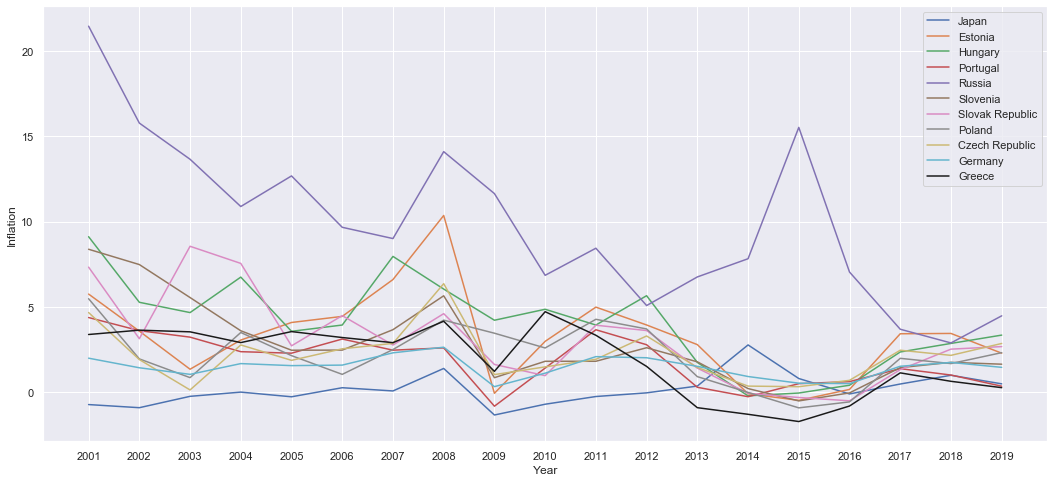

In [12]:
cpi_estonia = cpi_history.loc[cpi_history['Country'] == 'Estonia']
cpi_hungary = cpi_history.loc[cpi_history['Country'] == 'Hungary']
cpi_portugal = cpi_history.loc[cpi_history['Country'] == 'Portugal']
cpi_russia = cpi_history.loc[cpi_history['Country'] == 'Russia']
cpi_slovenia = cpi_history.loc[cpi_history['Country'] == 'Slovenia']
cpi_slovak = cpi_history.loc[cpi_history['Country'] == 'Slovak Republic']
cpi_poland = cpi_history.loc[cpi_history['Country'] == 'Poland']
cpi_czech = cpi_history.loc[cpi_history['Country'] == 'Czech Republic']
cpi_germany = cpi_history.loc[cpi_history['Country'] == 'Germany']
cpi_greece = cpi_history.loc[cpi_history['Country'] == 'Greece']

cpi_countries = [cpi_japan, cpi_estonia, cpi_hungary, cpi_portugal, cpi_russia, cpi_slovenia, cpi_slovak, cpi_poland,
                cpi_czech, cpi_germany, cpi_greece]

plt.figure(figsize=(18, 8))
for countries in cpi_countries:
    if countries is not cpi_greece:
        plt.plot(cpi_japan['Time'], countries['Value'], label=countries['Country'].unique()[0])
    else:
        plt.plot(cpi_japan['Time'], countries['Value'], 'k', label=countries['Country'].unique()[0])
plt.xticks(range(2001, 2020, 1))
plt.xlabel('Year')
plt.ylabel('Inflation')
plt.legend()
plt.show()

In [13]:
def create_standarized_dataset(data):
    """
    """
    # create pipeline
    data_copy = data.copy()
    
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="mean")),
        ('std_scaler', StandardScaler())
    ])
    transformed_data = num_pipeline.fit_transform(data_copy)
    
    data_copy[:] = transformed_data
    return data_copy

In [14]:
def get_top_10(data):
    """
    """
    return data.loc[
        (data.index == 'Estonia') |
        (data.index == 'Hungary') |
        (data.index == 'Portugal')|
        (data.index == 'Russia') |
        (data.index == 'Slovenia') |
        (data.index == 'Slovak Republic') |
        (data.index == 'Poland') |
        (data.index == 'Czech Republic') |
        (data.index == 'Germany') |
        (data.index == 'Greece') |
        (data.index == 'Japan')
    ]

In [15]:
# create data frame with relevant countries
ei_10 = get_top_10(create_standarized_dataset(economic_index))
cpi_10 = get_top_10(create_standarized_dataset(cpi_index))
gdp_production_10 = get_top_10(create_standarized_dataset(gdp_production_index))
health_10 = get_top_10(create_standarized_dataset(health_index))
ppp_10 = get_top_10(create_standarized_dataset(ppp_index))
productivity_ulc_10 = get_top_10(create_standarized_dataset(productivity_ulc_index))
population_10 = get_top_10(create_standarized_dataset(population_index))

In [16]:
pca = PCA(n_components=2)

ei_reduced = pca.fit_transform(ei_10)
cpi_reduced = pca.fit_transform(cpi_10)
gdp_production_reduced = pca.fit_transform(gdp_production_10)
health_reduced = pca.fit_transform(health_10)
productivity_ulc_reduced = pca.fit_transform(productivity_ulc_10)
population_reduced = pca.fit_transform(population_10)

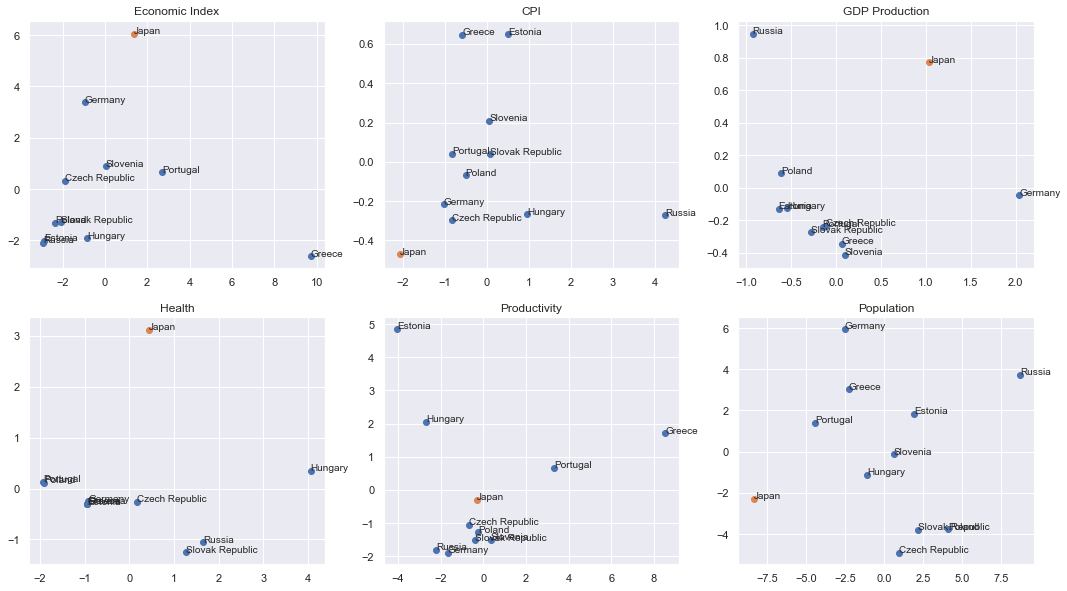

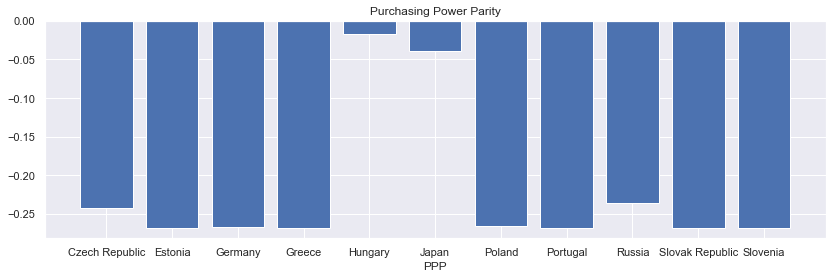

In [17]:
plt.figure(figsize=(18, 10))

index = 1
reduced_data = [("Economic Index", ei_reduced), ("CPI", cpi_reduced), ("GDP Production", gdp_production_reduced), 
                ("Health", health_reduced), ("Productivity", productivity_ulc_reduced), ("Population", population_reduced)]
for title, data in reduced_data:
    plt.subplot(2, 3, index)
    
    japan = data[5]
    others = np.delete(data, 5, 0)
    
    plt.scatter(others[:, 0], others[:, 1])
    plt.scatter(japan[0], japan[1])

    country_data = [x for x in ei_10.index if x != 'Japan']
    for i, txt in enumerate(country_data):
        plt.annotate(txt, (others[:, 0][i], others[:, 1][i]))
    plt.annotate("Japan", (japan[0], japan[1]))
    plt.title(title)
    
    index += 1
plt.show()

plt.figure(figsize=(14, 4))
plt.title('Purchasing Power Parity')
plt.xlabel('PPP')
plt.bar([x for x in ppp_10.index], np.ndarray.flatten(ppp_10.values))
plt.show()